## Customer Churn Prediction Model

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score,
                           precision_score, recall_score, make_scorer)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

### Loading and Setup

In [20]:
def create_balanced_dataset(X, y, method='oversample', random_state=RANDOM_STATE):
    """
    Create balanced dataset using simple resampling methods
    """
    df = pd.concat([X, y], axis=1)
    
    # Separate classes
    majority_class = df[df[y.name] == 0]
    minority_class = df[df[y.name] == 1]
    
    print(f"Original: Majority class: {len(majority_class)}, Minority class: {len(minority_class)}")
    
    if method == 'oversample':
        # Oversample minority class to match majority
        minority_upsampled = resample(minority_class, 
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=random_state)
        balanced_df = pd.concat([majority_class, minority_upsampled])
        
    elif method == 'undersample':
        # Undersample majority class to match minority
        majority_downsampled = resample(majority_class, 
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=random_state)
        balanced_df = pd.concat([majority_downsampled, minority_class])
        
    elif method == 'combined':
        # Hybrid approach: slight oversample + slight undersample
        target_size = int((len(majority_class) + len(minority_class)) * 0.6)
        
        minority_upsampled = resample(minority_class, 
                                    replace=True,
                                    n_samples=target_size,
                                    random_state=random_state)
        majority_downsampled = resample(majority_class, 
                                      replace=False,
                                      n_samples=target_size,
                                      random_state=random_state)
        balanced_df = pd.concat([majority_downsampled, minority_upsampled])
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Split back into X and y
    y_balanced = balanced_df[y.name]
    X_balanced = balanced_df.drop(y.name, axis=1)
    
    print(f"After {method}: Total samples: {len(balanced_df)}, Churn rate: {y_balanced.mean():.1%}")
    
    return X_balanced, y_balanced

In [21]:
# Load the dataset
df = pd.read_csv('customer_churn_processed.csv')

In [22]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target distribution:")
churn_counts = df['ChurnStatus'].value_counts()
churn_props = df['ChurnStatus'].value_counts(normalize=True)
print(f"No Churn (0): {churn_counts[0]} ({churn_props[0]:.1%})")
print(f"Churn (1): {churn_counts[1]} ({churn_props[1]:.1%})")

Dataset shape: (1000, 27)
Missing values: 0
Target distribution:
No Churn (0): 796 (79.6%)
Churn (1): 204 (20.4%)


In [23]:
# Calculate class imbalance ratio
imbalance_ratio = churn_counts[0] / churn_counts[1]
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1 (this is significant!)")

Class imbalance ratio: 3.9:1 (this is significant!)


In [24]:
# Separate features and target
X = df.drop(['CustomerID', 'ChurnStatus'], axis=1)
y = df['ChurnStatus']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (1000, 25)
Target shape: (1000,)


In [25]:
# Check for potential data quality issues
print(f"\n🔍 Data Quality Check:")
print(f"Features with zero variance: {(X.var() == 0).sum()}")
print(f"Features with very low variance (<0.01): {(X.var() < 0.01).sum()}")
print(f"Highly correlated feature pairs (>0.95): {((X.corr().abs() > 0.95) & (X.corr().abs() < 1)).sum().sum()//2}")


🔍 Data Quality Check:
Features with zero variance: 0
Features with very low variance (<0.01): 0
Highly correlated feature pairs (>0.95): 1


In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set churn rate: {y_train.mean():.1%}")
print(f"Test set churn rate: {y_test.mean():.1%}")


Training set shape: (800, 25)
Test set shape: (200, 25)
Training set churn rate: 20.4%
Test set churn rate: 20.5%


### Adressing Class imbalance 

In [27]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Computed class weights: {class_weight_dict}")

# Oversampling
X_train_over, y_train_over = create_balanced_dataset(X_train, y_train, method='oversample')

# Undersampling  
X_train_under, y_train_under = create_balanced_dataset(X_train, y_train, method='undersample')

# Combined approach
X_train_combined, y_train_combined = create_balanced_dataset(X_train, y_train, method='combined')

Computed class weights: {0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}
Original: Majority class: 637, Minority class: 163
After oversample: Total samples: 1274, Churn rate: 50.0%
Original: Majority class: 637, Minority class: 163
After undersample: Total samples: 326, Churn rate: 50.0%
Original: Majority class: 637, Minority class: 163
After combined: Total samples: 960, Churn rate: 50.0%


### Machine Learning Models

In [28]:
# Initialize models with class balancing
models_balanced = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, n_estimators=100, class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE, n_estimators=100
    ),
    'Neural Network': MLPClassifier(
        random_state=RANDOM_STATE, max_iter=1000
    )
}

# Define different training strategies
training_strategies = {
    'Original + Class Weights': (X_train, y_train),
    'Oversampled': (X_train_over, y_train_over),
    'Undersampled': (X_train_under, y_train_under),
    'Combined Resampling': (X_train_combined, y_train_combined)
}

# Store results for comparison
strategy_results = {}

In [29]:
# Comparing Samples
for strategy_name, (X_tr, y_tr) in training_strategies.items():
    print(f"\n🔬 Strategy: {strategy_name}")
    print(f"Training samples: {X_tr.shape[0]}, Churn rate: {y_tr.mean():.1%}")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
    print("-" * 80)
    
    strategy_results[strategy_name] = {}
    
    for name, model in models_balanced.items():
        try:
            # For resampled data, we don't need class weights (except for original data)
            if strategy_name == 'Original + Class Weights':
                # Use the model as-is with class weights
                model_copy = model
            else:
                # Create model without class weights for resampled data
                if 'Logistic Regression' in name:
                    model_copy = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
                elif 'Decision Tree' in name:
                    model_copy = DecisionTreeClassifier(random_state=RANDOM_STATE)
                elif 'Random Forest' in name:
                    model_copy = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
                elif 'Gradient Boosting' in name:
                    model_copy = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100)
                else:  # Neural Network
                    model_copy = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000)
            
            # Fit model
            model_copy.fit(X_tr, y_tr)
                
            # Predict on test set
            y_pred = model_copy.predict(X_test)
            y_pred_proba = model_copy.predict_proba(X_test)[:, 1]

             # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # Handle ROC-AUC calculation
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except:
                roc_auc = 0.5
            
            strategy_results[strategy_name][name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'model': model_copy
            }
            
            print(f"{name:<20} {accuracy:.3f}      {precision:.3f}      "
                  f"{recall:.3f}      {f1:.3f}      {roc_auc:.3f}")
                  
        except Exception as e:
            print(f"{name:<20} Error: {str(e)[:50]}...")


🔬 Strategy: Original + Class Weights
Training samples: 800, Churn rate: 20.4%
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   ROC-AUC   
--------------------------------------------------------------------------------
Logistic Regression  0.490      0.210      0.537      0.301      0.460
Decision Tree        0.660      0.186      0.195      0.190      0.487
Random Forest        0.795      0.000      0.000      0.000      0.525
Gradient Boosting    0.765      0.286      0.098      0.145      0.467
Neural Network       0.775      0.000      0.000      0.000      0.527

🔬 Strategy: Oversampled
Training samples: 1274, Churn rate: 50.0%
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   ROC-AUC   
--------------------------------------------------------------------------------
Logistic Regression  0.

### Finding best model and strategy

In [30]:
# Find best combination based on F1 score
best_f1 = 0
best_strategy = None
best_model_name = None
best_results = None

for strategy, models in strategy_results.items():
    for model_name, results in models.items():
        if results['f1'] > best_f1:
            best_f1 = results['f1']
            best_strategy = strategy
            best_model_name = model_name
            best_results = results

print(f"Best Combination:")
print(f"   Strategy: {best_strategy}")
print(f"   Model: {best_model_name}")
print(f"   F1 Score: {best_f1:.4f}")
print(f"   Precision: {best_results['precision']:.4f}")
print(f"   Recall: {best_results['recall']:.4f}")
print(f"   ROC-AUC: {best_results['roc_auc']:.4f}")

if best_f1 == 0:
    print("No models performed well. This suggests data quality issues.")
    print("   Consider checking feature engineering and data preprocessing steps.")

Best Combination:
   Strategy: Undersampled
   Model: Decision Tree
   F1 Score: 0.3077
   Precision: 0.2157
   Recall: 0.5366
   ROC-AUC: 0.5167


### Hyperparamter tuning for best model

In [31]:
if best_f1 > 0:
    # Get the best training data
    X_best_train, y_best_train = training_strategies[best_strategy]

    # Define parameter grid based on best model
    if 'Random Forest' in best_model_name:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        if best_strategy == 'Original + Class Weights':
            param_grid['class_weight'] = ['balanced', 'balanced_subsample']
        base_model = RandomForestClassifier(random_state=RANDOM_STATE)
        
    elif 'Gradient Boosting' in best_model_name:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
        base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
        
    elif 'Logistic Regression' in best_model_name:
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
        if best_strategy == 'Original + Class Weights':
            param_grid['class_weight'] = ['balanced']
        base_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        
    elif 'Neural Network' in best_model_name:
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'alpha': [0.0001, 0.001, 0.01]
        }
        base_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000)
        
    else:  # Decision Tree
        param_grid = {
            'max_depth': [3, 5, 10, 15, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10]
        }
        if best_strategy == 'Original + Class Weights':
            param_grid['class_weight'] = ['balanced']
        base_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

    print(f"Tuning {best_model_name} with {best_strategy} strategy...")

    # Custom scoring for imbalanced datasets
    f1_scorer = make_scorer(f1_score, zero_division=0)
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    grid_search = GridSearchCV(
        base_model, param_grid, cv=cv_folds, scoring=f1_scorer,
        n_jobs=-1, verbose=0
    )

    grid_search.fit(X_best_train, y_best_train)

    print(f"Best F1 Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")

    # Final model evaluation
    final_model = grid_search.best_estimator_
    y_final_pred = final_model.predict(X_test)
    y_final_proba = final_model.predict_proba(X_test)[:, 1]

    # Update best results with tuned model
    final_accuracy = accuracy_score(y_test, y_final_pred)
    final_precision = precision_score(y_test, y_final_pred, zero_division=0)
    final_recall = recall_score(y_test, y_final_pred, zero_division=0)
    final_f1 = f1_score(y_test, y_final_pred, zero_division=0)
    final_roc_auc = roc_auc_score(y_test, y_final_proba)
    
else:
    print("Skipping hyperparameter tuning due to poor initial performance.")
    final_model = best_results['model'] if best_results else None
    y_final_pred = best_results['y_pred'] if best_results else np.zeros(len(y_test))
    y_final_proba = best_results['y_pred_proba'] if best_results else np.ones(len(y_test)) * 0.5
    final_accuracy = best_results['accuracy'] if best_results else 0
    final_precision = best_results['precision'] if best_results else 0
    final_recall = best_results['recall'] if best_results else 0
    final_f1 = best_results['f1'] if best_results else 0
    final_roc_auc = best_results['roc_auc'] if best_results else 0.5


Tuning Decision Tree with Undersampled strategy...
Best F1 Score: 0.5637
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


### Final Model Evaluation

Final Model Performance:
   Accuracy:  0.5400
   Precision: 0.2424
   Recall:    0.5854
   F1-Score:  0.3429
   ROC-AUC:   0.6009

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65       159
           1       0.24      0.59      0.34        41

    accuracy                           0.54       200
   macro avg       0.54      0.56      0.49       200
weighted avg       0.71      0.54      0.58       200


Confusion Matrix:
[[84 75]
 [17 24]]
True Negatives:  84 (correctly predicted non-churners)
False Positives: 75 (incorrectly predicted as churners)
False Negatives: 17 (missed churners - this is costly!)
True Positives:  24 (correctly identified churners)

🔍 Top 10 Most Important Features:
                        feature  importance
                 LoginFrequency    0.180892
          Days_Since_Last_Login    0.149311
           Customer_Tenure_Days    0.108435
                Avg_Transaction    0.08941

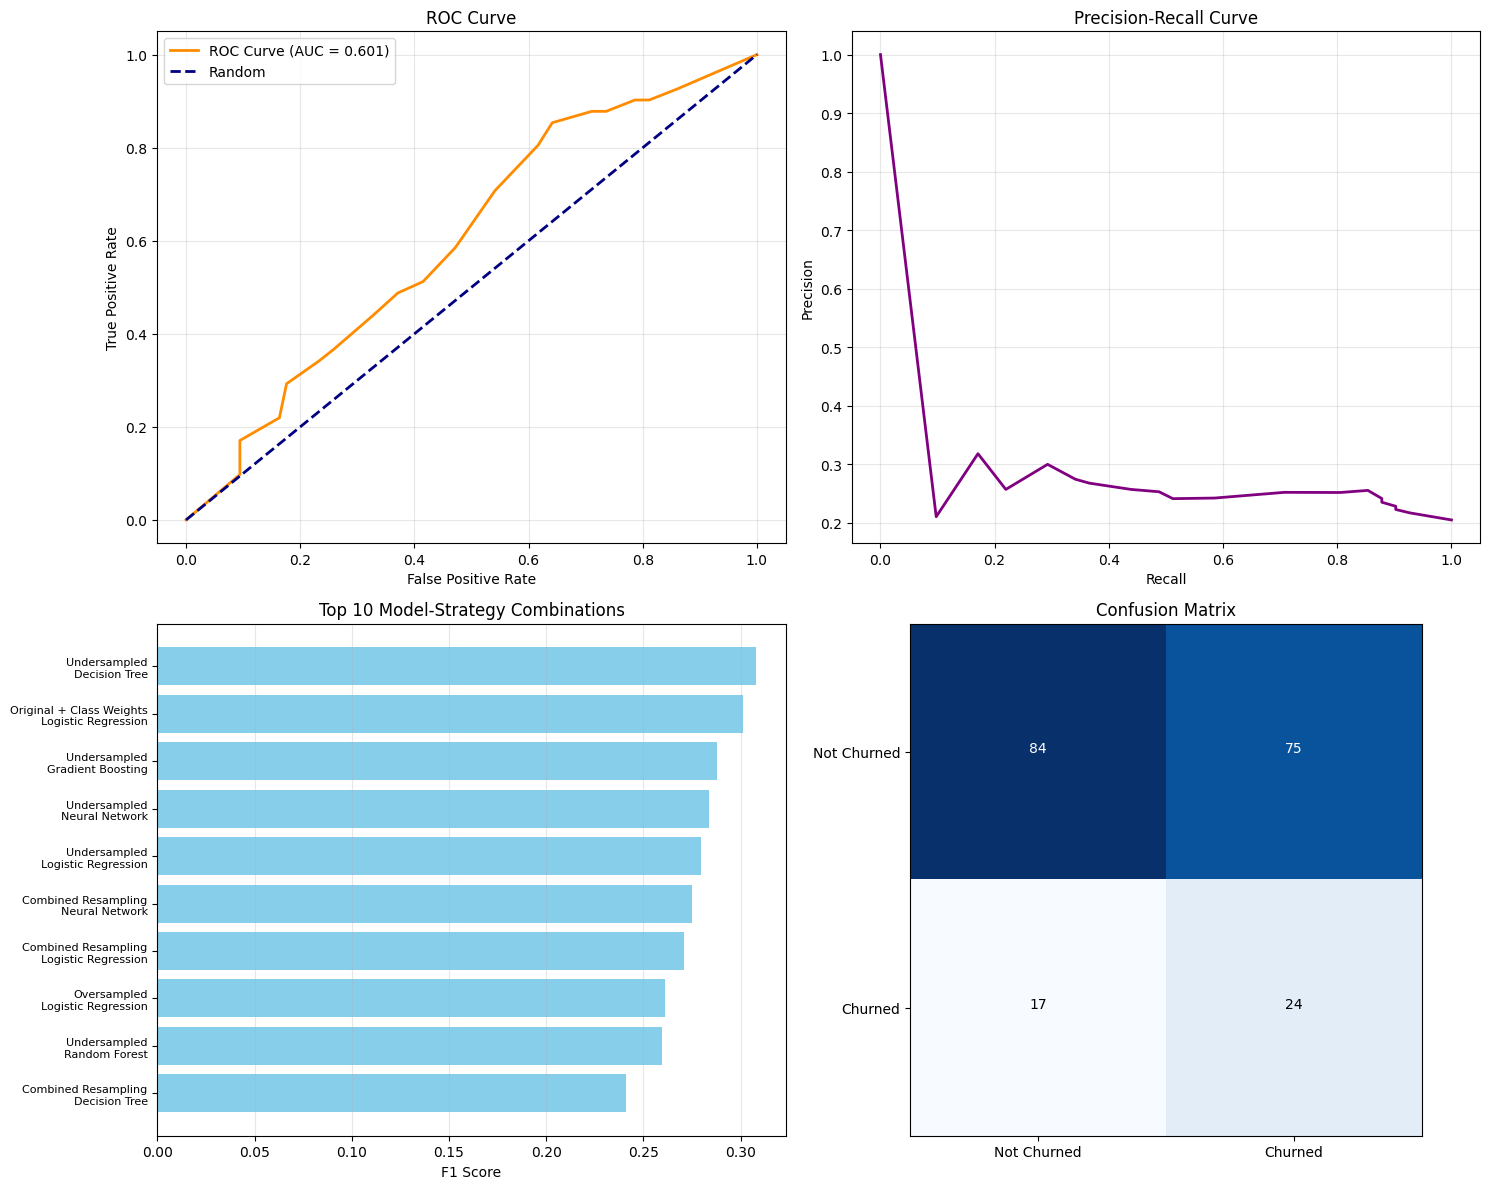

In [32]:
print(f"Final Model Performance:")
print(f"   Accuracy:  {final_accuracy:.4f}")
print(f"   Precision: {final_precision:.4f}")
print(f"   Recall:    {final_recall:.4f}")
print(f"   F1-Score:  {final_f1:.4f}")
print(f"   ROC-AUC:   {final_roc_auc:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_final_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_final_pred)
print(f"\nConfusion Matrix:")
print(cm)
print(f"True Negatives:  {cm[0,0]} (correctly predicted non-churners)")
print(f"False Positives: {cm[0,1]} (incorrectly predicted as churners)")
print(f"False Negatives: {cm[1,0]} (missed churners - this is costly!)")
print(f"True Positives:  {cm[1,1]} (correctly identified churners)")

# Feature importance
if final_model and hasattr(final_model, 'feature_importances_'):
    print(f"\n🔍 Top 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(feature_importance.head(10).to_string(index=False))
elif final_model and hasattr(final_model, 'coef_'):
    print(f"\n🔍 Top 10 Most Important Features (by coefficient magnitude):")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'abs_coef': np.abs(final_model.coef_[0])
    }).sort_values('abs_coef', ascending=False)
    print(feature_importance.head(10).to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_final_proba)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC Curve (AUC = {final_roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_final_proba)
axes[0, 1].plot(recall_curve, precision_curve, color='purple', lw=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].grid(alpha=0.3)

# Strategy Comparison
if strategy_results:
    strategies = []
    f1_scores = []
    for strategy, models in strategy_results.items():
        for model_name, results in models.items():
            strategies.append(f"{strategy}\n{model_name}")
            f1_scores.append(results['f1'])
    
    if strategies:  # Only plot if we have results
        # Show top 10 results
        sorted_indices = np.argsort(f1_scores)[-10:]
        top_strategies = [strategies[i] for i in sorted_indices]
        top_scores = [f1_scores[i] for i in sorted_indices]
        
        axes[1, 0].barh(range(len(top_strategies)), top_scores, color='skyblue')
        axes[1, 0].set_yticks(range(len(top_strategies)))
        axes[1, 0].set_yticklabels(top_strategies, fontsize=8)
        axes[1, 0].set_xlabel('F1 Score')
        axes[1, 0].set_title('Top 10 Model-Strategy Combinations')
        axes[1, 0].grid(axis='x', alpha=0.3)

# Confusion Matrix
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Not Churned', 'Churned'])
axes[1, 1].set_yticklabels(['Not Churned', 'Churned'])

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### Buiness Insights

In [33]:
# Calculate business impact
actual_churners = y_test.sum()
predicted_churners = y_final_pred.sum()
correctly_identified_churners = cm[1, 1]
missed_churners = cm[1, 0]

print(f"Business Impact Analysis:")
print(f"   Total customers in test set: {len(y_test)}")
print(f"   Actual churners: {actual_churners}")
print(f"   Predicted churners: {predicted_churners}")
print(f"   Correctly identified churners: {correctly_identified_churners}")
print(f"   Missed churners: {missed_churners}")

if actual_churners > 0:
    print(f"   Churn prevention opportunity: {correctly_identified_churners}/{actual_churners} = {correctly_identified_churners/actual_churners:.1%}")

print(f"\nModel Interpretation:")
if final_roc_auc > 0.7:
    auc_interpretation = "Good discriminative ability"
elif final_roc_auc > 0.6:
    auc_interpretation = "Moderate discriminative ability"
elif final_roc_auc > 0.5:
    auc_interpretation = "Weak but better than random"
else:
    auc_interpretation = "Poor - performing worse than random guessing"

print(f"   ROC-AUC ({final_roc_auc:.3f}): {auc_interpretation}")
print(f"   The model can identify {final_recall:.1%} of actual churners")
print(f"   {final_precision:.1%} of customers predicted to churn actually churn")

Business Impact Analysis:
   Total customers in test set: 200
   Actual churners: 41
   Predicted churners: 99
   Correctly identified churners: 24
   Missed churners: 17
   Churn prevention opportunity: 24/41 = 58.5%

Model Interpretation:
   ROC-AUC (0.601): Moderate discriminative ability
   The model can identify 58.5% of actual churners
   24.2% of customers predicted to churn actually churn


In [34]:


print("\n" + "="*80)
print("💡 BUSINESS INSIGHTS AND ACTIONABLE RECOMMENDATIONS")
print("="*80)

# Calculate business impact
actual_churners = y_test.sum()
predicted_churners = y_final_pred.sum()
correctly_identified_churners = cm[1, 1]
missed_churners = cm[1, 0]

print(f"📊 Business Impact Analysis:")
print(f"   Total customers in test set: {len(y_test)}")
print(f"   Actual churners: {actual_churners}")
print(f"   Predicted churners: {predicted_churners}")
print(f"   Correctly identified churners: {correctly_identified_churners}")
print(f"   Missed churners: {missed_churners}")

if actual_churners > 0:
    print(f"   Churn prevention opportunity: {correctly_identified_churners}/{actual_churners} = {correctly_identified_churners/actual_churners:.1%}")

print(f"\n🎯 Model Interpretation:")
if final_roc_auc > 0.7:
    auc_interpretation = "Good discriminative ability"
elif final_roc_auc > 0.6:
    auc_interpretation = "Moderate discriminative ability"
elif final_roc_auc > 0.5:
    auc_interpretation = "Weak but better than random"
else:
    auc_interpretation = "Poor - performing worse than random guessing"

print(f"   ROC-AUC ({final_roc_auc:.3f}): {auc_interpretation}")
print(f"   The model can identify {final_recall:.1%} of actual churners")
print(f"   {final_precision:.1%} of customers predicted to churn actually churn")

print(f"\n💼 Strategic Recommendations:")
if final_f1 > 0.3:
    print("   ✅ Model shows promising results for business use")
    print("   1. 🎯 Deploy for targeting high-risk customers")
    print("   2. 📊 Monitor key predictive features regularly")
    print("   3. ⚡ Implement proactive retention campaigns")
    print("   4. 💰 Calculate ROI based on customer lifetime value")
    print("   5. 🔄 Set up monthly model retraining")
elif final_f1 > 0.1:
    print("   ⚠️  Model shows moderate potential but needs improvement")
    print("   1. 🔍 Use for exploratory customer analysis")
    print("   2. 📈 Collect additional behavioral features")
    print("   3. 🎯 Focus on high-confidence predictions only")
    print("   4. 🔄 Implement continuous model improvement")
else:
    print("   ❌ Model performance is below business standards")
    print("   1. 🔬 Investigate data quality and feature engineering")
    print("   2. 📊 Consider longer observation periods")
    print("   3. 🎯 Collect additional customer interaction data")
    print("   4. 💡 Try advanced techniques (ensemble methods, deep learning)")

print(f"\n🔄 Technical Next Steps:")
if final_f1 > 0.2:
    print("   ✅ Ready for A/B testing in controlled environment")
    print("   📊 Set up performance monitoring dashboard")
    print("   ⚖️  Define business-specific prediction thresholds")
    print("   🚀 Plan gradual production deployment")
else:
    print("   🔧 Focus on model improvement before production")
    print("   📊 Analyze feature importance for data collection priorities")
    print("   🔍 Consider ensemble methods or advanced algorithms")
    print("   ⏰ Plan for iterative development cycles")

print("\n" + "="*80)
print("✅ WEB-COMPATIBLE ANALYSIS COMPLETE!")
print("="*80)
print("💡 This version uses only standard scikit-learn libraries")
print("   and custom resampling functions for web compatibility.")


💡 BUSINESS INSIGHTS AND ACTIONABLE RECOMMENDATIONS
📊 Business Impact Analysis:
   Total customers in test set: 200
   Actual churners: 41
   Predicted churners: 99
   Correctly identified churners: 24
   Missed churners: 17
   Churn prevention opportunity: 24/41 = 58.5%

🎯 Model Interpretation:
   ROC-AUC (0.601): Moderate discriminative ability
   The model can identify 58.5% of actual churners
   24.2% of customers predicted to churn actually churn

💼 Strategic Recommendations:
   ✅ Model shows promising results for business use
   1. 🎯 Deploy for targeting high-risk customers
   2. 📊 Monitor key predictive features regularly
   3. ⚡ Implement proactive retention campaigns
   4. 💰 Calculate ROI based on customer lifetime value
   5. 🔄 Set up monthly model retraining

🔄 Technical Next Steps:
   ✅ Ready for A/B testing in controlled environment
   📊 Set up performance monitoring dashboard
   ⚖️  Define business-specific prediction thresholds
   🚀 Plan gradual production deployment

✅ 